In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import keras_tuner as kt

## Preprocessing

In [2]:
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
noID_application_df = application_df.drop(columns = ["EIN", "NAME"])

In [4]:
# Determine the number of unique values in each column.
noID_application_df[noID_application_df.columns].nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [5]:
# Look at APPLICATION_TYPE value counts to identify and replace with "Other"
noID_application_df["APPLICATION_TYPE"].value_counts()

APPLICATION_TYPE
T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: count, dtype: int64

In [6]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
application_types_to_replace = ["T9", "T13", "T12", "T2", "T25", "T14", "T29", "T15", "T17"]

# Replace in dataframe
for app in application_types_to_replace:
    noID_application_df['APPLICATION_TYPE'] = noID_application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure replacement was successful
noID_application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: count, dtype: int64

In [7]:
# Look at CLASSIFICATION value counts to identify and replace with "Other"
noID_application_df["CLASSIFICATION"].value_counts(sort=False)

CLASSIFICATION
C1000    17326
C2000     6074
C3000     1918
C1200     4837
C2700      104
         ...  
C1248        1
C6100        1
C1820        1
C1900        1
C2150        1
Name: count, Length: 71, dtype: int64

In [8]:
# creating two individual lists that can be iterated over in parallel. 
#These are not joined together because value_counts() does not return a value description when loaded into a variable.
#sort=False is passed into value_counts() because unique() also returns an unsorted list. In this configuration, both just return values in the order they are observed in the dataframe.
unique_vals = noID_application_df["CLASSIFICATION"].value_counts(sort=False) # (1)
unique_cats = noID_application_df["CLASSIFICATION"].unique()

In [9]:
# Choose a cutoff value and create a list of classifications to be replaced
classifications_to_replace = [unique_cats[i] for i in range(0,len(unique_vals)) if unique_vals.iloc[i] < 1000]

# Replace in dataframe
for classification in classifications_to_replace:
    noID_application_df['CLASSIFICATION'] = noID_application_df['CLASSIFICATION'].replace(classification,"Other")

# Check to make sure replacement was successful
noID_application_df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: count, dtype: int64

In [10]:
noID_application_df[noID_application_df.columns].nunique()

APPLICATION_TYPE             9
AFFILIATION                  6
CLASSIFICATION               6
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [11]:
# Convert categorical data to numeric with `pd.get_dummies`
# OPTIMIZATION 1: remove 'status' and 'special consideration' columns to reduce dimensionality.
categorical_target_cols = noID_application_df.drop(columns=['STATUS', 'SPECIAL_CONSIDERATIONS',"ASK_AMT","IS_SUCCESSFUL"]).columns

# Module 19; Lesson 2; Activity 4
#https://stackoverflow.com/questions/77643432/why-is-pd-get-dummies-returning-boolean-values-instead-of-the-binaries-of-0-1
dummies = pd.get_dummies(noID_application_df[categorical_target_cols], dtype = int)

In [12]:
#combine non-categorical columns with new dummy columns
final_df = pd.concat([dummies, noID_application_df[["ASK_AMT","IS_SUCCESSFUL"]]], axis = 1) # Module 19; Lesson 2; Activity 4

In [13]:
# Split our preprocessed data into our features and target arrays
X = final_df.drop(columns=["IS_SUCCESSFUL"])
y = final_df["IS_SUCCESSFUL"]

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

In [27]:
#Instantiate neural network model
nn = tf.keras.models.Sequential()

# First hidden layer
#OPTIMIZATION# 2: INCREASE INPUT UNITS
nn.add(tf.keras.layers.Dense(units=120, activation = 'relu', input_dim = len(X_train_scaled[0])))

#OPTIMIZATION #3: add dropou
nn.add(tf.keras.layers.Dropout(0.4)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=40, activation = 'relu'))

nn.add(tf.keras.layers.Dropout(0.25))

#OPTIMIZATION# 4: add additional hidden layer
nn.add(tf.keras.layers.Dense(units=20, activation = 'relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 120)            │         4,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,601 (41.41 KB)

 Trainable params: 10,601 (41.41 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [29]:
# Train the model
#OPTIMIZATION #5: add additional training epochs
fit_model = nn.fit(X_train_scaled, y_train, epochs = 1000)

Epoch 1/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 302us/step - accuracy: 0.6787 - loss: 0.6190
Epoch 2/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - accuracy: 0.7233 - loss: 0.5758
Epoch 3/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - accuracy: 0.7286 - loss: 0.5637
Epoch 4/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7330 - loss: 0.5596
Epoch 5/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.7291 - loss: 0.5577
Epoch 6/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.7307 - loss: 0.5568
Epoch 7/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.7379 - loss: 0.5475
Epoch 8/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.7350 - loss: 0.5539
Epoch 9/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.7311 - loss: 0.5556
Epoch 10/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.7313 - loss: 0.5530
Epoch 11/1000
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.7360 - loss: 0.5484
Epoch 12

In [30]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - 333us/step - accuracy: 0.7236 - loss: 0.5711
Loss: 0.571149468421936, Accuracy: 0.7236151695251465


In [31]:
# Export our model to HDF5 file
nn.save('models/AlphabetSoupCharity_Optimization.h5')#https://www.tensorflow.org/guide/keras/serialization_and_saving

In [32]:
loss_df = pd.DataFrame(fit_model.history)
loss_df.index += 1

accuracy_df = pd.DataFrame(fit_model.history)
accuracy_df.index += 1

(<Axes: >, <Axes: >)

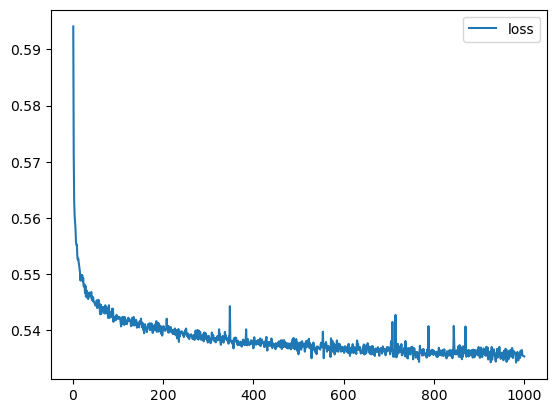

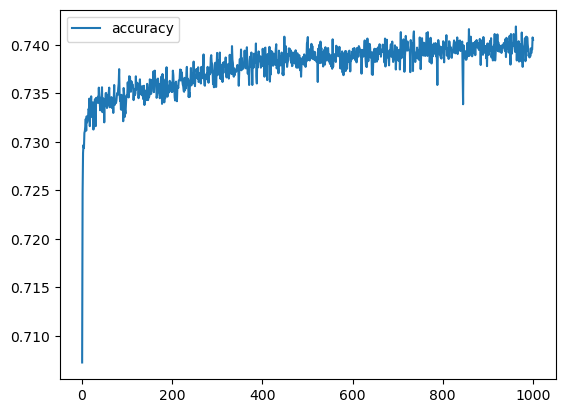

In [33]:
loss_plot = loss_df.plot(kind='line', y = 'loss')
accuracy_plot = accuracy_df.plot(kind='line', y = 'accuracy')

loss_plot, accuracy_plot